## Initial Imports

In [1]:
import numpy as np
import pandas as pd
import ipdb
import pprint
import sys
import matplotlib.pyplot as plt

eps = np.finfo(float).eps
from numpy import log2 as log

## Reading Data

In [2]:
data = pd.read_csv("../input_data/train.csv")
data.columns = ['satisfaction', 'last_eval', 'no_project', 'avg_monthly_hrs', 'time_spend', 'accident', 'left', 'promotion_last_5yrs', 'sales', 'salary']

test_data = pd.read_csv("../input_data/sample_test.csv")

# renaming the attributes
test_data.columns = ['satisfaction', 'last_eval', 'no_project', 'avg_monthly_hrs', 'time_spend', 'accident', 'promotion_last_5yrs', 'sales', 'salary']

# Random Selection of 80% Training Data and 20% Validation Data
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
validate = data[~msk]

# Selecting first 80% as Training Data and remaining as Validation Data
# train, validate = np.split(data, [int(.8*len(data))])

numerical_attributes = ['satisfaction', 'last_eval', 'no_project', 'avg_monthly_hrs', 'time_spend']
categorical_attributes = ['accident', 'promotion_last_5yrs', 'sales', 'salary']

## Utility Functions

In [3]:
def get_impurity(impurity_measure, q):
    if impurity_measure == "entropy":
        return -(q * log(q+eps)) - ((1-q) * log((1-q)+eps))
    elif impurity_measure == "gini_index":
        return 2 * q * (1-q)
    else: # misclassification_rate
        return min(q, 1-q)

In [4]:
def find_categorical_impurity(df, attribute, impurity_measure):
    Class = "left"
    target_variables = df[Class].unique()
    attValues = df[attribute].unique()
    attValues.sort()

    if len(attValues) == 1:
        return float(sys.maxsize)

    arr = df[[attribute, Class]].values
    arr = arr[np.argsort(arr[:, 0])]

    weighted_impurity = 0
    total_rows = arr.shape[0]
    i = 0
    for value in attValues:
        impurity = 0
        num = 0
        den = 0

        while (i < total_rows and arr[i][0] == value) :
            if arr[i][1] == target_variables[0]:
                num += 1
            den += 1
            i += 1

        q = float(num)/(den)
        impurity = get_impurity(impurity_measure, q)

        # add to the weighted average
        weight = float(den)/total_rows
        weighted_impurity += -(weight * impurity)

    return abs(weighted_impurity)

In [5]:
def find_categorical_winner(df, impurity_measure):
    min_impurity = float(sys.maxsize)
    min_attr = ""
    for attr in categorical_attributes:
        impurity = find_categorical_impurity(df, attr, impurity_measure)
        if impurity < min_impurity:
            min_attr = attr
            min_impurity = impurity

    return (min_attr, min_impurity)

In [6]:
def find_numerical_winner(df, impurity_measure):
    Class = "left"
    target_variables = df[Class].unique()
    total_target_1 = df[Class].value_counts()[target_variables[0]]

    min_impurity = float(sys.maxsize)
    min_attr = ""
    min_threshold = 0.0
    for key in numerical_attributes:
        thresholds = df[key].unique()
        thresholds.sort()

        if len(thresholds) == 1:
            continue

        arr = df[[key, Class]].values
        arr = arr[np.argsort(arr[:, 0])]
        total_rows = arr.shape[0]

        i = 0
        num = 0
        for t in thresholds[:-1]:    
            weighted_impurity = 0
            while (i < total_rows and arr[i][0] == t) :
                if arr[i][1] == target_variables[0]:
                    num += 1
                i += 1

            q = float(num)/(i)
            impurity = get_impurity(impurity_measure, q)
            # add to the weighted average
            weight = float(i)/total_rows
            weighted_impurity += -(weight * impurity)

            q = float(total_target_1 - num)/(total_rows - i)
            impurity = get_impurity(impurity_measure, q)
            # add to the weighted average
            weight = float(total_rows - i)/total_rows
            weighted_impurity += -(weight * impurity)

            weighted_impurity = abs(weighted_impurity)

            if weighted_impurity < min_impurity:
                min_attr = key
                min_impurity = weighted_impurity
                min_threshold = t

    return (min_attr, min_impurity, min_threshold)

In [7]:
def predict_with_max_height(test_sample, tree, max_height, curr_height):
    #This function is used to predict for any input variable 
    #Recursively we go through the tree that we built earlier

    if type(tree) is not dict:
        return tree
    
    nOnes = tree["nOnes"]
    nZeros = tree["nZeros"]
    if curr_height == max_height:
        if nOnes >= nZeros:
            return 1
        return 0

    tree_keys = list(tree.keys())
    attr = None
    for i in range(len(tree_keys)):
        if (tree_keys[i] is not "nZeros") and (tree_keys[i] is not "nOnes"):
            attr = tree_keys[i]
            break

    value = test_sample[attr]

    if attr in categorical_attributes:
        if value is tree[attr]:
            tree = tree[attr][value]
        elif nOnes >= nZeros:
            tree = 1
        else:
            tree = 0
    else:
        threshold = list(tree[attr].keys())
        if value <= threshold[0]:
            tree = tree[attr][threshold[0]]
        else:
            tree = tree[attr][threshold[1]]

    return predict_with_max_height(test_sample, tree, max_height, curr_height+1)

In [8]:
def predict_with_min_size(test_sample, tree, min_size):
    #This function is used to predict for any input variable 
    #Recursively we go through the tree that we built earlier

    if type(tree) is not dict:
        return tree

    nOnes = tree["nOnes"]
    nZeros = tree["nZeros"]
    if nOnes + nZeros <= min_size:
        if nOnes >= nZeros:
            return 1
        return 0

    tree_keys = list(tree.keys())
    attr = None
    for i in range(len(tree_keys)):
        if (tree_keys[i] is not "nZeros") and (tree_keys[i] is not "nOnes"):
            attr = tree_keys[i]
            break

    value = test_sample[attr]

    if attr in categorical_attributes:
        if value is tree[attr]:
            tree = tree[attr][value]
        elif nOnes >= nZeros:
            tree = 1
        else:
            tree = 0
    else:
        threshold = list(tree[attr].keys())
        if value <= threshold[0]:
            tree = tree[attr][threshold[0]]
        else:
            tree = tree[attr][threshold[1]]

    return predict_with_min_size(test_sample, tree, min_size)

In [9]:
def tree_validation(validation_data, tree, validation_type, limit):
    TP = 0; FP = 0; TN = 0; FN = 0;

    for index, validation_sample in validation_data.iterrows():
        if validation_type == "height_check":
            prediction = predict_with_max_height(validation_sample, tree, limit, 0)
        elif validation_type == "size_check":
            prediction = predict_with_min_size(validation_sample, tree, limit)
        else:
            print ("Invalid validation type!!!")
            return 0.0

        if prediction == 1:
            if prediction == validation_sample['left']:
                TP += 1
            else:
                FP += 1
        else:
            if prediction == validation_sample['left']:
                TN += 1
            else:
                FN += 1

    accuracy = float(TP + TN) / (TP + FP + TN + FN)
    if TP == 0:
        recall = 0.0
        precision = 0.0
        f1_score = 2 / ((1/(eps)) + (1/(eps)))
    else:
        recall = float(TP) / (TP + FN)
        precision = float(TP) / (TP + FP)
        f1_score = 2 / ((1/(recall)) + (1/(precision)))

#     print ("TP = {}, TN = {}, FP = {}, FN = {}".format(TP, TN, FP, FN))
#     print ("accuracy = {}, recall = {}, precision = {}, f1_score = {}".format(accuracy, recall, precision, f1_score))
    return (accuracy, recall, precision, f1_score)

In [10]:
def get_subtable(df, node, value):
    return df[df[node] == value].reset_index(drop=True)

In [11]:
def get_subtable_le(df, node, value):
    return df[df[node] <= value].reset_index(drop=True)

In [12]:
def get_subtable_gt(df, node, value):
    return df[df[node] > value].reset_index(drop=True)

# Part-1: Decision Tree only on Categorical Data

In [13]:
def buildTree_categorical(df, impurity_measure): 
    Class = "left"
    labels = df[Class].unique()

    if len(labels) == 1:
        return labels[0]

    # Get attribute with minimum entropy
    attr, min_impurity = find_categorical_winner(df, impurity_measure)
    
    ones_count = df[Class].value_counts()[1]
    zeros_count = df[Class].value_counts()[0]

    # Gain is zero for all the attributes
    if (min_impurity == float(sys.maxsize)):
        if ones_count >= zeros_count:
            return 1
        return 0

    tree = {}
    tree[attr] = {}
    tree["nOnes"] = ones_count
    tree["nZeros"] = zeros_count

    attValues = df[attr].unique()

    for value in attValues:
        subtable = get_subtable(df, attr, value)
        tree[attr][value] = buildTree_categorical(subtable, impurity_measure)

    return tree

In [14]:
DT_categorical_entropy = buildTree_categorical(train, "entropy")
A_entropy, R_entropy, P_entropy, F1_entropy = tree_validation(validate, DT_categorical_entropy, "height_check", sys.maxsize)

In [15]:
DT_categorical_gini = buildTree_categorical(train, "gini_index")
A_gini, R_gini, P_gini, F1_gini = tree_validation(validate, DT_categorical_gini, "height_check", sys.maxsize)

In [16]:
DT_categorical_misclass = buildTree_categorical(train, "misclassification_rate")
A_misclass, R_misclass, P_misclass, F1_misclass = tree_validation(validate, DT_categorical_misclass, "height_check", sys.maxsize)

* Using **Entropy**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_entropy * 100, 2)}} | {{round(R_entropy * 100, 2)}} | {{round(P_entropy * 100, 2)}} | {{round(F1_entropy, 2)}}

* Using **Gini-index**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_gini * 100, 2)}} | {{round(R_gini * 100, 2)}} | {{round(P_gini * 100, 2)}} | {{round(F1_gini, 2)}}

* Using **Misclassification-Rate**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_misclass * 100, 2)}} | {{round(R_misclass * 100, 2)}} | {{round(P_misclass * 100, 2)}} | {{round(F1_misclass, 2)}}

# Part-2 & Part-3

In [17]:
def buildTree(df, impurity_measure): 
    Class = "left"
    labels = df[Class].unique()

    if len(labels) == 1:
        return labels[0]

    # Get attribute with minimum entropy
    numerical_attribute, numerical_min_impurity, threshold = find_numerical_winner(df, impurity_measure)
    categorical_attribute, categorical_min_impurity = find_categorical_winner(df, impurity_measure)

    nOnes = df[Class].value_counts()[1]
    nZeros = df[Class].value_counts()[0]
    if (categorical_min_impurity == float(sys.maxsize)) and (numerical_min_impurity == float(sys.maxsize)):
        if nOnes >= nZeros:
            return 1
        return 0

    tree = {}
    tree["nOnes"] = nOnes
    tree["nZeros"] = nZeros

    if categorical_min_impurity < numerical_min_impurity:
        attr = categorical_attribute
        tree[attr] = {}

        attValues = df[attr].unique()

        for value in attValues:
            subtable = get_subtable(df, attr, value)
            tree[attr][value] = buildTree(subtable, impurity_measure)
    else:
        attr = numerical_attribute
        tree[attr] = {}

        subtable_le = get_subtable_le(df, attr, threshold)
        tree[attr][threshold] = buildTree(subtable_le, impurity_measure)

        subtable_gt = get_subtable_gt(df, attr, threshold)
        tree[attr][float(threshold)+0.0001] = buildTree(subtable_gt, impurity_measure)

    return tree

### Decision Tree with Categorical and Numerical features

In [18]:
DT_entropy = buildTree(train, "entropy")
A_entropy, R_entropy, P_entropy, F1_entropy = tree_validation(validate, DT_entropy, "height_check", sys.maxsize)

In [19]:
DT_gini = buildTree(train, "gini_index")
A_gini, R_gini, P_gini, F1_gini = tree_validation(validate, DT_gini, "height_check", sys.maxsize)

In [20]:
DT_misclass = buildTree(train, "misclassification_rate")
A_misclass, R_misclass, P_misclass, F1_misclass = tree_validation(validate, DT_misclass, "height_check", sys.maxsize)

* Using **Entropy**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_entropy * 100, 2)}} | {{round(R_entropy * 100, 2)}} | {{round(P_entropy * 100, 2)}} | {{round(F1_entropy, 2)}}

* Using **Gini-index**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_gini * 100, 2)}} | {{round(R_gini * 100, 2)}} | {{round(P_gini * 100, 2)}} | {{round(F1_gini, 2)}}

* Using **Misclassification Rate**

| Accuracy (%) | Recall (%) | Precision (%) | F1_Score
| :-: | :-: | :-: | :-:
| {{round(A_misclass * 100, 2)}} | {{round(R_misclass * 100, 2)}} | {{round(P_misclass * 100, 2)}} | {{round(F1_misclass, 2)}}

# Part-4: Decision Boundary

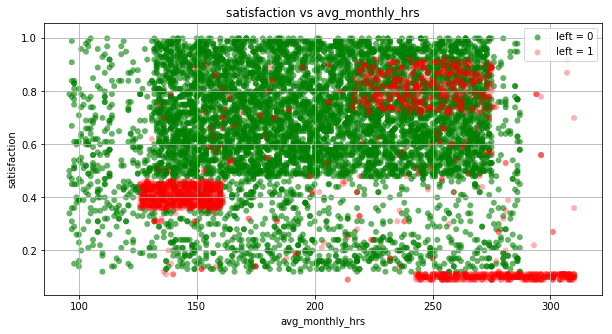

In [21]:
Class = "left"
features = numerical_attributes + categorical_attributes

fig, ax = plt.subplots(figsize=(10,5))
x = train["avg_monthly_hrs"][data[Class] == 0]
y = train["satisfaction"][data[Class] == 0]
ax.scatter(x, y, c='green', label='left = 0', alpha=0.6, edgecolors='none')

x = train["avg_monthly_hrs"][data[Class] == 1]
y = train["satisfaction"][data[Class] == 1]
ax.scatter(x, y, c='red', label='left = 1', alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.title("satisfaction vs avg_monthly_hrs")
plt.xlabel("avg_monthly_hrs")
plt.ylabel("satisfaction")
plt.show()

### left = 1
 * __Region 1:__ (0.37 <= satisfaction <= 0.47) and (130 <= average monthly hours <= 160)<br>
 * __Region 2:__ (satisfaction <= 0.1) and (240 <= average monthly hours <= 315)
 * __Region 3:__ (0.7 <= satisfaction <= 0.9)   and (215 <= average monthly hours <= 275)

# Part-5

### Error Rates vs Depth

In [22]:
y_train_error = []
y_validate_error = []
x = range(1, 21)

for i in x:
    p = (1.0 - tree_validation(train, DT_entropy, "height_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_entropy, "height_check", i)[0]) * 100
    y_validate_error.append(p)

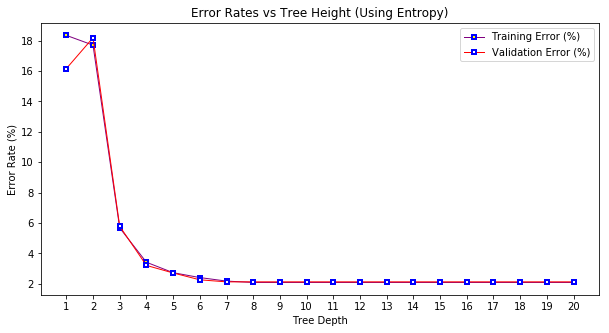

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Tree Height (Using Entropy)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

In [24]:
y_train_error = []
y_validate_error = []
x = range(1, 21)

for i in x:
    p = (1.0 - tree_validation(train, DT_gini, "height_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_gini, "height_check", i)[0]) * 100
    y_validate_error.append(p)

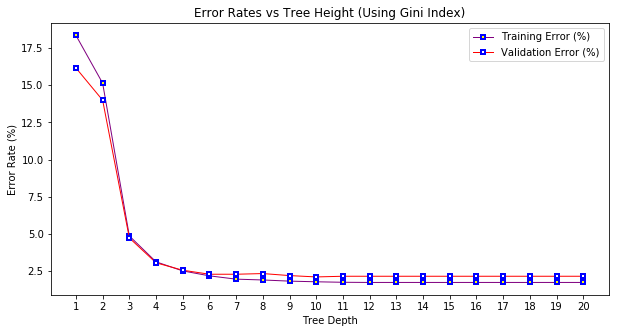

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Tree Height (Using Gini Index)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

In [29]:
y_train_error = []
y_validate_error = []
x = range(1, 21)

for i in x:
    p = (1.0 - tree_validation(train, DT_misclass, "height_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_misclass, "height_check", i)[0]) * 100
    y_validate_error.append(p)

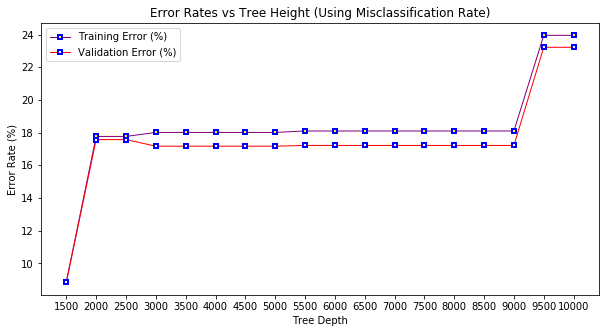

In [34]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Tree Height (Using Misclassification Rate)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Tree Depth")
plt.legend()
plt.show()

### Error Rates vs Node Size

In [31]:
y_train_error = []
y_validate_error = []
x = range(10000, 1000, -500)

for i in x:
    p = (1.0 - tree_validation(train, DT_entropy, "size_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_entropy, "size_check", i)[0]) * 100
    y_validate_error.append(p)

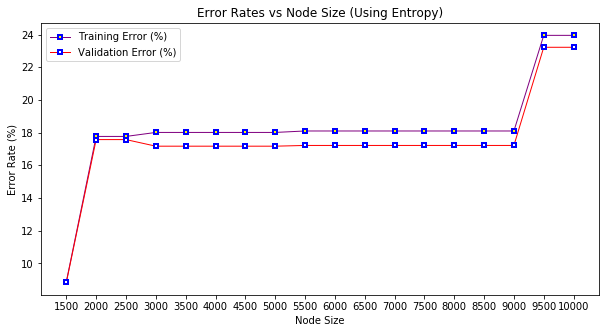

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Node Size (Using Entropy)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Node Size")
plt.legend()
plt.show()

In [49]:
y_train_error = []
y_validate_error = []
x = range(10000, 1000, -500)

for i in x:
    p = (1.0 - tree_validation(train, DT_gini, "size_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_gini, "size_check", i)[0]) * 100
    y_validate_error.append(p)

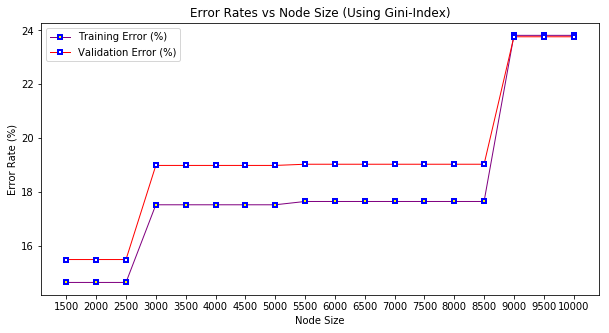

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Node Size (Using Gini-Index)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Node Size")
plt.legend()
plt.show()

In [51]:
y_train_error = []
y_validate_error = []
x = range(10000, 1000, -500)

for i in x:
    p = (1.0 - tree_validation(train, DT_misclass, "size_check", i)[0]) * 100
    y_train_error.append(p)
    p = (1.0 - tree_validation(validate, DT_misclass, "size_check", i)[0]) * 100
    y_validate_error.append(p)

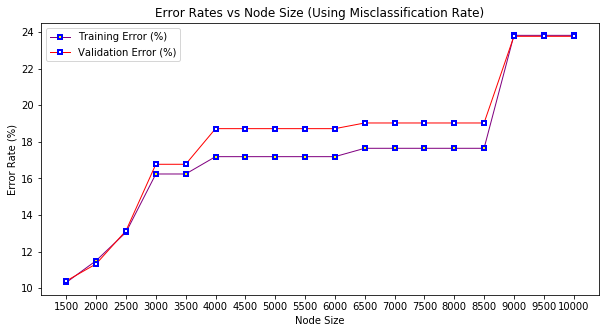

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y_train_error, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Training Error (%)');
ax.plot(x, y_validate_error, color="red", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="white", markeredgewidth=2, markeredgecolor="blue", label='Validation Error (%)');

plt.xticks(x)
plt.title("Error Rates vs Node Size (Using Misclassification Rate)")
plt.ylabel("Error Rate (%)")
plt.xlabel("Node Size")
plt.legend()
plt.show()

# Part-6: Ways to handle with missing values while testing

1. Disregard all attributes after the first missing attribute.<br>
On seeing a missing attribute, the prediction is made probabilistically, regardless of all other attributes.

 2. Consider all attributes other than the missing ones in the test sample.<br>
 Like method 1, the prediction is made probabilisitically, however, it is fine tuned by considering<nr>
 non-missing attributes as well.

3. Guess the missing attribute. <br>
Categorical Attributes are guessed by picking the maximum occurring value.<br>
Numerical Attributes are guessed by taking the mean or median of the data.